In [5]:
import sys
sys.path.append('../')
from deep_rl.simple_grid.env import DiscreteGridWorld
from deep_rl.network import *
from deep_rl.utils import *
from sklearn.decomposition import NMF
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import torch.nn.functional as F

def set_seed(t, r=None, p=None, c=None):
    if r is None:
        r = t
    if p is None:
        p = r
    torch.manual_seed(t)
    random.seed(r)
    np.random.seed(p)
    if c is not None:
        torch.cuda.manual_seed(c)

set_seed(0)
        
class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 20)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.05 * v)) for v in range(1, 20)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.05 * v)) for v in range(1, 20)],
    *[('green-{}'.format(v), plt.cm.Greens(0.05 * v)) for v in range(1, 20)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.05 * v)) for v in range(1, 20)],
    *[('red-{}'.format(v), plt.cm.Reds(0.05 * v)) for v in range(1, 20)],
])

def imshow(img):
    display(Image.fromarray(np.asarray(img)))

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
drawer = GridDrawer(color_list)

# multitask NMF from: https://ieeexplore.ieee.org/document/6939673
class MTNMF:
    def __init__(self, n_components, l1_ratio=0.0, max_iter=200, tol=0.0001):
        self.n_components = n_components
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol

    def loss(self, X, A, S):
        return 0.5 * ((X - np.matmul(A, S)) ** 2).sum() + self.l1_ratio * S.sum()
        
    # input: a stack of observed data X_1, ..., X_K
    # output: S, A_1, ..., A_K
    def fit(self, X):
        K, N, M = X.shape
        A = np.random.rand(K, N, self.n_components)
        S = np.random.rand(self.n_components, M)
        prev_loss = np.inf
        cur_loss = None
        for i in range(self.max_iter):
            A_T = A.transpose(0, 2, 1)
            new_S = S * (np.matmul(A_T, X).sum(0)) / (np.matmul(np.matmul(A_T, A), S).sum(0) + K * self.l1_ratio * np.ones((self.n_components, M)))
            S = new_S
            new_A = A * np.matmul(X, S.T) / np.matmul(np.matmul(A, S), S.T)
            A = new_A
            cur_loss = self.loss(X, A, S)
            if i % 100 == 0: print('NMF loss:', cur_loss)
            if abs(cur_loss - prev_loss) < self.tol: break
            prev_loss = cur_loss # update loss
        return A, S, {'loss': cur_loss, 'iter': i}

In [6]:
visualization_map = dict([
    ('G', 0), # goal
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 100)],
])

def get_states(env):
    # get the whole state space
    states = []
    for i in range(env.size[0]):
        for j in range(env.size[1]):
                if env.is_valid_loc((i, j)):
                    states.append((i, j))
    infos = {'task_id': [0] * len(states)} 
    return states, infos

def get_img(env, abs_list):
    indices = np.zeros(env.size, dtype=np.int64)
    k = 0
    for i in range(env.size[0]):
        for j in range(env.size[1]):
            if (i, j) == env.goal:
                indices[i, j] = 0
            elif env.map[i][j] == '#':
                indices[i, j] = 1
            else:
                indices[i, j] = visualization_map[str(2 + abs_list[k])]
                k += 1

    img = drawer.draw(indices)
    return img


# Single NMF

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 1), (3, 2), (3, 3), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 1), (4, 2), (4, 3), (4, 4), (4, 6), (4, 7), (4, 8), (4, 9), (5, 2), (5, 6), (5, 7), (5, 8), (5, 9), (6, 1), (6, 2), (6, 3), (6, 4), (6, 8), (7, 1), (7, 2), (7, 3), (7, 4), (7, 6), (7, 7), (7, 8), (7, 9), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 1), (9, 2), (9, 3), (9, 4), (9, 6), (9, 7), (9, 8)]
n_states: 67


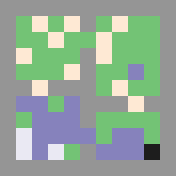

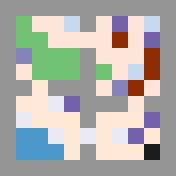

In [98]:
n_abs = 10
l1_ratio = 0.0
state_dim = 2
n_action = 4

set_seed(0)

env = DiscreteGridWorld('fourroom', (1, 1), (9, 9))
decomposer = NMF(n_abs, solver='mu', random_state=0, max_iter=5000, l1_ratio=l1_ratio)

expert = CategoricalActorCriticNet(
    1,
    state_dim,
    n_action,
    FCBody(
        state_dim, 
        hidden_units=(16,)
    ),  
)
# load weight
weight_dict = expert.state_dict()
loaded_weight_dict = {k: v for k, v in torch.load(
    'log/grid.fourroom.9_9/fc_discrete.baseline/_/0.190228-203237/models/step-128000-mean-1.00',
    map_location=lambda storage, loc: storage)['network'].items()
    if k in weight_dict}
weight_dict.update(loaded_weight_dict)
expert.load_state_dict(weight_dict)


states, infos = get_states(env)                
print(states)
print('n_states:', len(states))
                
actions = expert(np.array(states), infos)['a'] # maybe take the whole distribution

img = get_img(env, actions.cpu().detach().numpy())
imshow(img)

pvs = F.softmax(expert.get_logits(np.array(states), infos), dim=1).cpu().detach().numpy()
#pvs = one_hot.encode(actions, n_action).cpu().detach().numpy()
abs_mat = decomposer.fit_transform(pvs)
policy_mat = decomposer.components_

abs_list = np.array(abs_mat).argmax(1)
#print(abs_list)
abs_map = {s: i for s, i in zip(states, abs_mat)}
#print(abs_map)
fsave(abs_map, 'data/abs/grid/fourroom/single.{}.l1-{}'.format(n_abs, l1_ratio), 'pkl')

img = get_img(env, abs_list)
imshow(img)

# MultiTask NMF (shared states)

/home/liyuc/anaconda3/envs/tsa/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 5000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


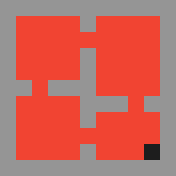

In [11]:
n_abs = 4
l1_ratio=0.0 # this is currently not working... since alpha is not set
state_dim = 2
n_action = 4

set_seed(0)

expert_dict = {
    (1, 1): '../log/grid.fourroom.1_1.md-1.T-100/fc_discrete.baseline/_/0.190303-160012/models/step-160000-mean-1.00',
    (9, 1): '../log/grid.fourroom.9_1.md-1.T-100/fc_discrete.baseline/_/0.190303-160151/models/step-160000-mean-1.00',
    (1, 9): '../log/grid.fourroom.1_9.md-1.T-100/fc_discrete.baseline/_/0.190303-160103/models/step-160000-mean-1.00',
}
env = DiscreteGridWorld('fourroom', (1, 1), (9, 9))
decomposer = NMF(n_abs, solver='mu', random_state=0, max_iter=5000, l1_ratio=l1_ratio)
#decomposer = NMF(n_abs, solver='mu', beta_loss='kullback-leibler', random_state=0, max_iter=5000, l1_ratio=l1_ratio)
states, infos = get_states(env)
states.append(env.goal)
infos['task_id'].append(0)
pvs = []

for goal_loc, weight_path in expert_dict.items():
    expert = CategoricalActorCriticNet(
        1,
        state_dim,
        n_action,
        FCBody(
            state_dim, 
            hidden_units=(16,)
        ),  
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    pvs.append(F.softmax(expert.get_logits(np.array(states), infos), dim=1).cpu().detach().numpy())

pvs = np.concatenate(pvs, 1)
abs_mat = decomposer.fit_transform(pvs)
policy_mat = decomposer.components_

abs_list = np.array(abs_mat).argmax(1) # argmax moved to algo as an option
#print(abs_list)
abs_map = {s: i for s, i in zip(states, abs_mat)}
#print(abs_map)
fsave(abs_map, 'data/abs/grid/fourroom/MTS.{}.l1-{}'.format(n_abs, l1_ratio), 'pkl')

img = get_img(env, abs_list)
imshow(img)

# MultiTask NMF (does not shared states) 

NMF loss: 21.535784134215312
NMF loss: 5.721383821928558
NMF loss: 5.611648883803544


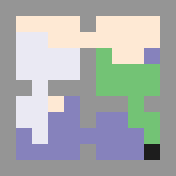

In [7]:
n_abs = 4
l1_ratio=0.0
state_dim = 2
n_action = 4

set_seed(0)

expert_dict = {
    (1, 1): '../log/grid.fourroom.1_1.md-1.T-100/fc_discrete.baseline/_/0.190303-160012/models/step-160000-mean-1.00',
    (9, 1): '../log/grid.fourroom.9_1.md-1.T-100/fc_discrete.baseline/_/0.190303-160151/models/step-160000-mean-1.00',
    (1, 9): '../log/grid.fourroom.1_9.md-1.T-100/fc_discrete.baseline/_/0.190303-160103/models/step-160000-mean-1.00',
}
env = DiscreteGridWorld('fourroom', (1, 1), (9, 9))
decomposer = MTNMF(n_abs, max_iter=5000, tol=0.0001)
states, infos = get_states(env)
states.append(env.goal)
infos['task_id'].append(0)
pvs = []

for goal_loc, weight_path in expert_dict.items():
    expert = OldCategoricalActorCriticNet(
        1,
        state_dim,
        n_action,
        FCBody(
            state_dim, 
            hidden_units=(16,) # this have changed...
        ),  
    )
    # load weight
    #weight_dict = expert.state_dict()
    #loaded_weight_dict = {k: v for k, v in torch.load(
    #    weight_path,
    #    map_location=lambda storage, loc: storage)['network'].items()
    #    if k in weight_dict}
    #weight_dict.update(loaded_weight_dict)
    #expert.load_state_dict(weight_dict)
    expert.load_state_dict(torch.load(weight_path, map_location=lambda storage, loc: storage)['network'])
    pvs.append(F.softmax(expert.get_logits(np.array(states), infos), dim=1).cpu().detach().numpy())

pvs = np.stack(pvs, 0)
A, S, info = MTNMF(n_abs, max_iter=5000, l1_ratio=l1_ratio).fit(pvs.transpose(0, 2, 1))

abs_list = S.T.argmax(1)
#abs_map = {s: i for s, i in zip(states, abs_mat)}
#fsave(abs_map, 'data/abs/grid/fourroom/MT.{}.l1-{}'.format(n_abs, l1_ratio), 'pkl')

# save nmf_smaple
# fsave(
#     dict(
#         abs=S.T,
#         policies=list(pvs),
#         states=[states for _ in range(3)],
#         infos=list([[{'task_id': i} for _ in range(len(states))] for i in range(3)]),
#     ),
#     'data/nmf_sample/grid/fourroom/{}'.format(n_abs),
#     'pkl',
# )

img = get_img(env, abs_list)
imshow(img)